## Setup, Loading Data and CDFs

In [7]:
DATA_NAME = 'ravdess-1e5rawre' #dataset-compression
TRANSFORM = 'stft-female' #transform-group
CHANNEL = ''
NUM_BANDS = int(10) 

In [8]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
female_stft_1e5rawre_ravdess.ipynb


In [9]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results-audio", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'band' 
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'e:\\Research\\UCB\\Strang Lab\\Github\\hierarchical-bayesian-model-validation\\results-audio\\case-studies\\ravdess\\1e5rawre\\stft\\female'

In [10]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [11]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data-audio", "subsample-data", f'{FULL_DATA_NAME}-size.pickle'))

In [12]:
if 'erb' in TRANSFORM:
    group_data_map.popitem()
NUM_BANDS = max(min(NUM_BANDS, len(group_data_map) - 2), 1)

In [13]:
#if 'fourier' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
#elif 'wavelet' in TRANSFORM:
#    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)
#GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::max(len(group_data_map) // NUM_BANDS, 1)]
GROUPS = np.linspace(2, sorted(group_data_map)[-1], NUM_BANDS, dtype=int)


cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
#group_total_samples
#group_data_map


Running 12760 CDFs


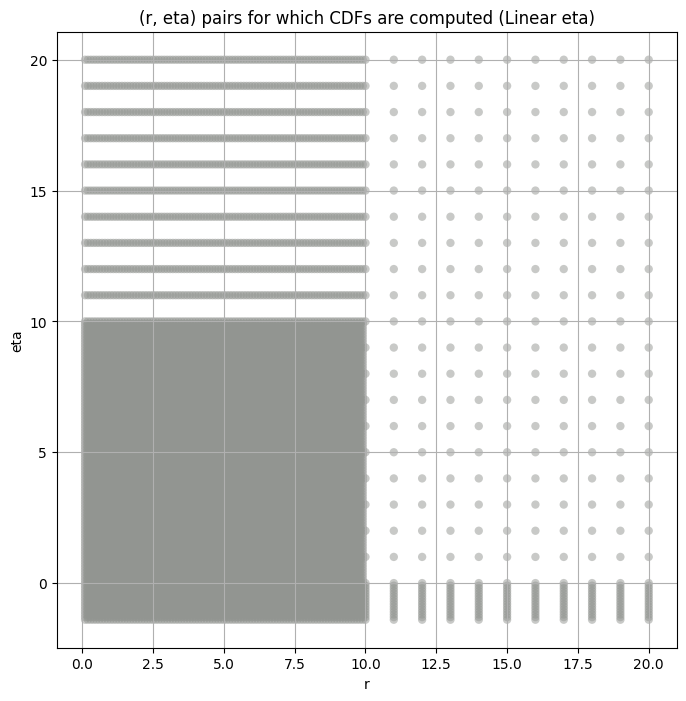

,"(r,eta),cdf",r,eta,cdf,variance,kurtosis
0,"((0.1, -1.4), <scipy.interpolate._fitpack2.Int...",0.1,-1.4,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.628800e+06,554265.000000
1,"((0.1, -1.3), <scipy.interpolate._fitpack2.Int...",0.1,-1.3,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.991680e+07,96192.272727
2,"((0.1, -1.2), <scipy.interpolate._fitpack2.Int...",0.1,-1.2,<scipy.interpolate._fitpack2.InterpolatedUniva...,2.395008e+08,29390.000000
3,"((0.1, -1.1), <scipy.interpolate._fitpack2.Int...",0.1,-1.1,<scipy.interpolate._fitpack2.InterpolatedUniva...,1.037837e+09,11997.692308
4,"((0.1, -1.0), <scipy.interpolate._fitpack2.Int...",0.1,-1.0,<scipy.interpolate._fitpack2.InterpolatedUniva...,3.632429e+09,5874.890110


In [14]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [15]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [16]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Band 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Band 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples
band,,,,,,,
2,74.898780,60.582530,96.669820,81.446304,26.894161,243.59503,7281120.0
3,29.164696,24.408790,36.506966,59.589302,21.501167,199.60582,7281120.0
4,17.610868,13.961561,26.559898,175.805450,27.692068,671.88556,7281120.0
5,14.123198,10.813453,22.130413,221.240480,40.726257,784.53310,29124480.0
6,4.266520,3.277308,6.358692,176.742780,42.272380,626.33920,14562240.0
7,0.997323,0.778492,1.400140,131.501680,39.621890,462.65570,14562240.0
8,0.378813,0.285862,0.610266,248.776430,44.356453,863.71990,14562240.0
9,0.267987,0.185539,0.490132,447.445000,68.904110,1361.17110,14789775.0


## Initial Grid Search and Hypothesis Test Plots

In [17]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [18]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

,obs_var,var_exclude_0,var_exclude_25,var_exclude_50,var_exclude_75,var_exclude_100,var_exclude_150,var_exclude_200,var_exclude_250,var_exclude_300,var_exclude_350,var_exclude_500
band,,,,,,,,,,,,
2,74.898780,74.898781,64.419456,60.110817,57.046249,54.622166,50.863552,47.969830,45.593506,43.575115,41.817677,37.588863
3,29.164696,29.164696,25.926888,24.509434,23.449781,22.584639,21.195286,20.089664,19.161427,18.361755,17.657143,15.936957
4,17.610868,17.610868,14.936693,13.980338,13.272003,12.698509,11.783984,11.063466,10.467591,9.958403,9.513645,8.443826
5,14.123198,14.123198,11.726324,10.836800,10.163062,9.609426,8.722869,8.020134,7.437559,6.940062,6.507292,5.478818
6,4.266520,4.266520,3.547292,3.266493,3.056962,2.886146,2.614823,2.402031,2.226271,2.076545,1.946555,1.638968
7,0.997323,0.997323,0.845078,0.781522,0.733651,0.694440,0.631495,0.581725,0.540456,0.505236,0.474604,0.401769
8,0.378813,0.378813,0.312352,0.287165,0.268046,0.252346,0.227314,0.207691,0.191609,0.178012,0.166311,0.138988
9,0.267987,0.267987,0.204076,0.181539,0.165079,0.152003,0.131929,0.116849,0.104898,0.095128,0.086966,0.068928


####
Band  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.0036839785504015343 74.89878


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.004334649596742457 64.41946


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.002693595031758138 60.110817


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.0036745157823346863 57.04625


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.004658379411620506 54.622166


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.00619462953435676 50.863552


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.005143883039923747 47.96983


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.0062911936778331755 45.593506


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.007583062153836341 43.575115


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.008923181840122425 41.817677


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.008714450793158246 37.588863
Number of samples: 100000, Without approximation : 7281120.0


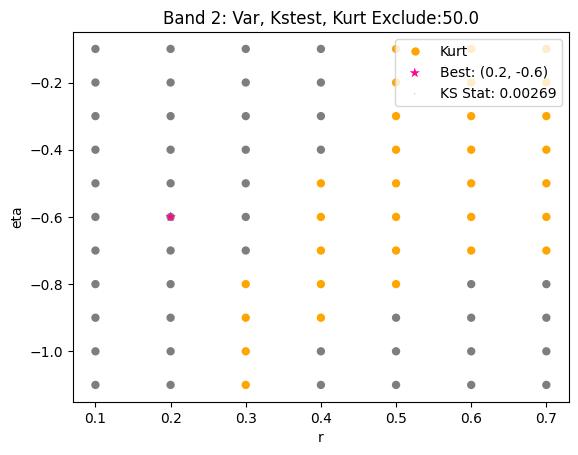

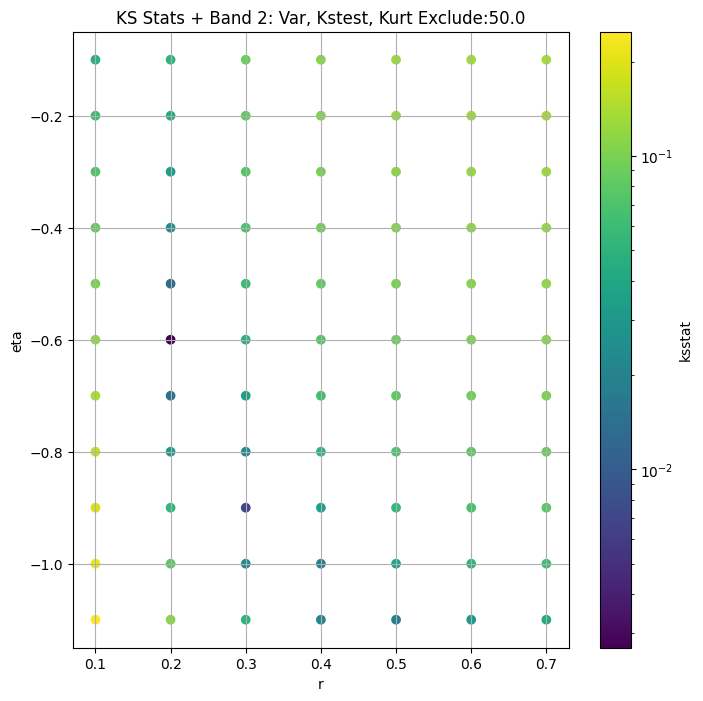

####
Band  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.005825590492580274 29.164696


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.006285762282755347 25.926888


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.0028382715531796165 24.509434


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.002512790077355387 23.449781


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.003400006253176456 22.584639


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.005654073393400183 21.195286


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.004429307189049901 20.089664


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.00552322721588645 19.161427


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.0067058036937753945 18.361755


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.006938718288908019 17.657143


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.008260056253356476 15.936957
Number of samples: 100000, Without approximation : 7281120.0


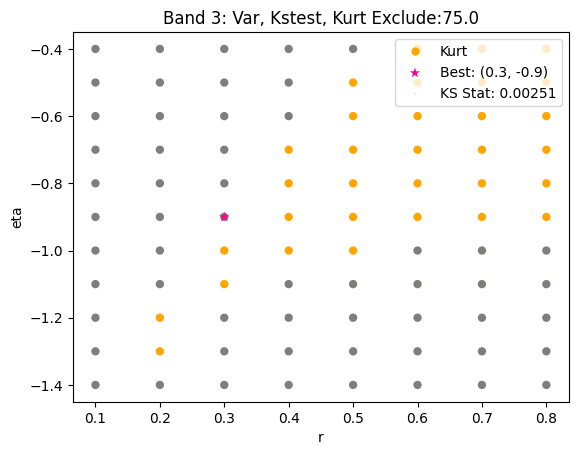

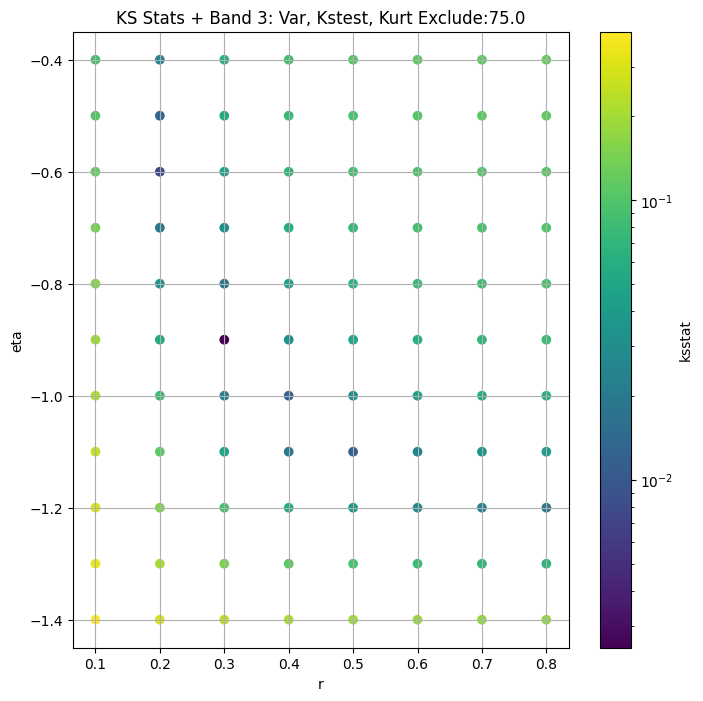

####
Band  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.009382810912920703 17.610868


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.0037982186199915224 14.936693


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.007462125944237175 13.980338


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.0056469036703219455 13.272003


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.003503442071709384 12.698509


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.004503872553437212 11.783984


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.0066648870861211185 11.063466


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.008731177835786808 10.467591


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.009439288673654234 9.958403


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.010123525733677974 9.513645


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.008475459678615259 8.443826
Number of samples: 100000, Without approximation : 7281120.0


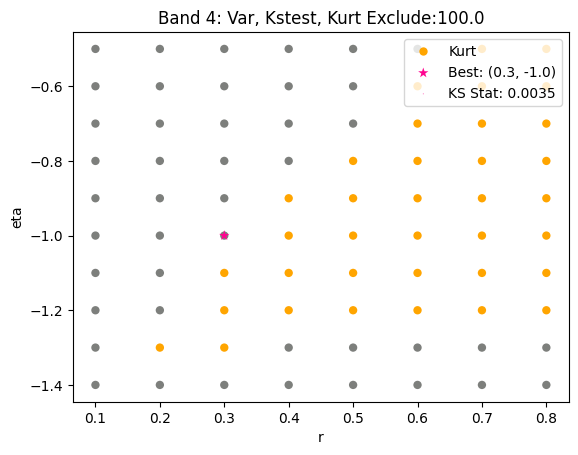

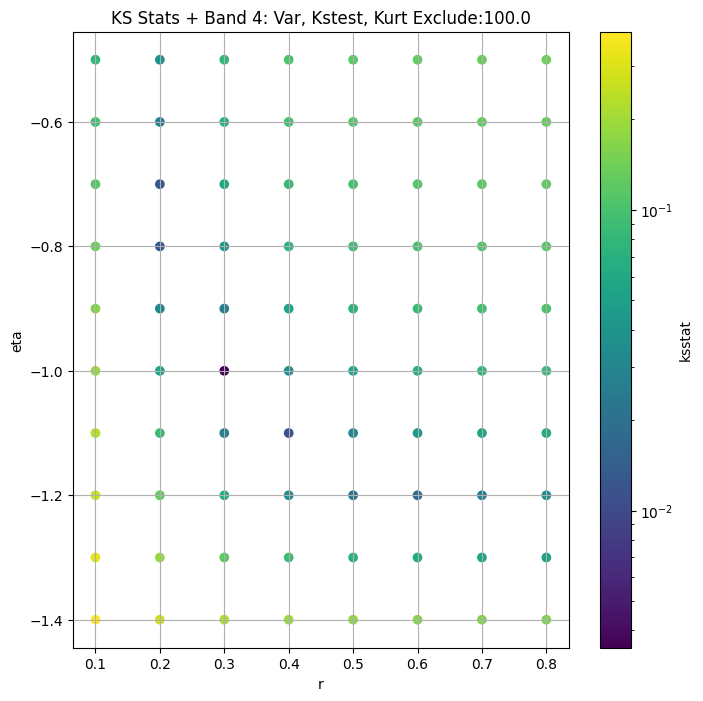

####
Band  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.009992893586497131 14.123198


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.010096763758644434 11.726324


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.0060996646873979765 10.8368


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.005321678487229267 10.163062


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.006112534490189392 9.609426


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.0065457854111726395 8.722869


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.0076573218085558 8.020134


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.008037549123076033 7.4375587


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.009015163190005247 6.9400616


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.010020573442219061 6.507292


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.009815490491398732 5.4788184
Number of samples: 100000, Without approximation : 29124480.0


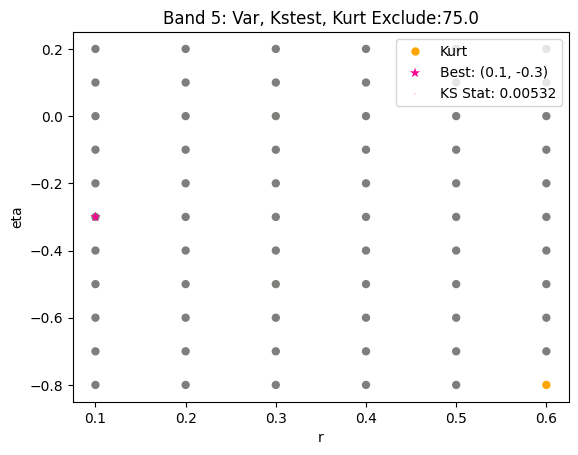

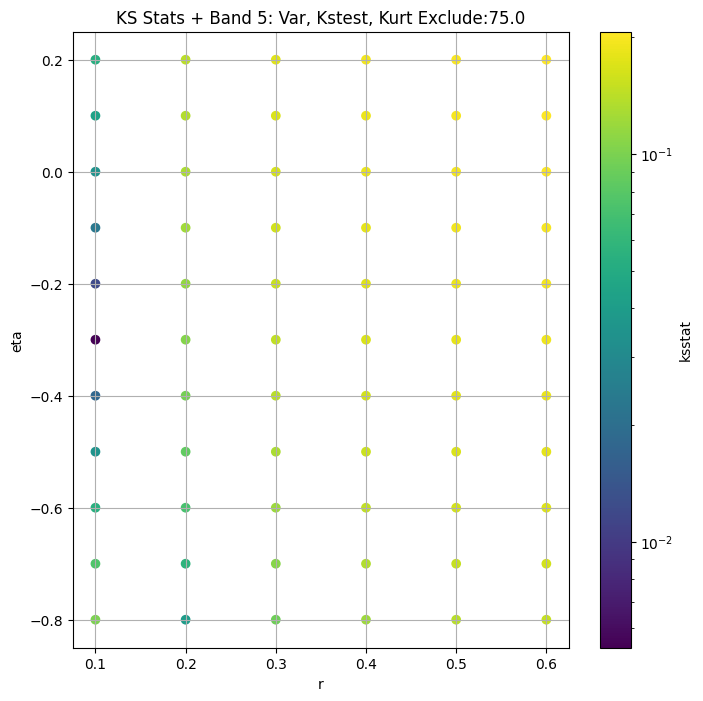

####
Band  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.013827769067606854 4.26652


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.008568140563589899 3.5472925


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.011119560359455383 3.2664928


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.00897366691500312 3.0569623


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.006079057057993387 2.886146


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.008415108281873335 2.614823


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.007015976426707881 2.4020312


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.007516266359338471 2.2262707


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.008409141346007941 2.0765445


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.008848348571744057 1.9465553


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.00985678903041437 1.6389685
Number of samples: 100000, Without approximation : 14562240.0


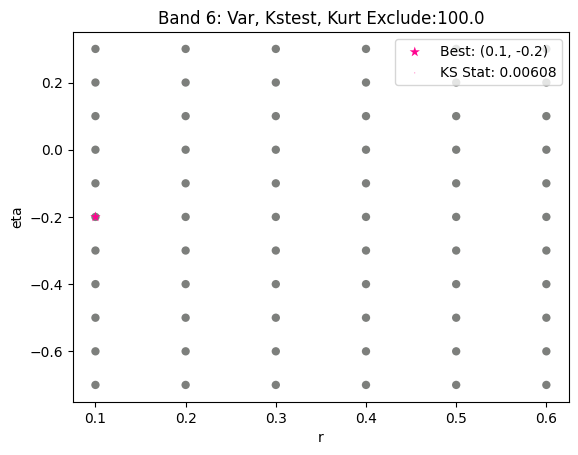

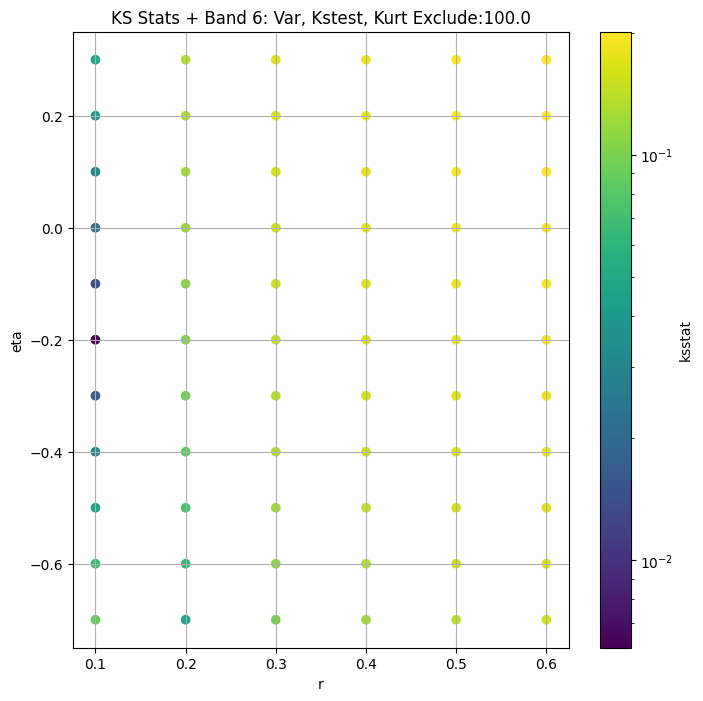

####
Band  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.014957861288677154 0.9973231


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.013626616685706194 0.8450779


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.00958721312555988 0.7815222


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.010251125658515936 0.7336513


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.009894230117505232 0.6944398


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.006857192025997327 0.63149494


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.006450484600285189 0.58172536


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.007054541459726513 0.5404557


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.007592816963668189 0.50523645


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.008130700741658194 0.4746041


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.010150059262821292 0.40176925
Number of samples: 100000, Without approximation : 14562240.0


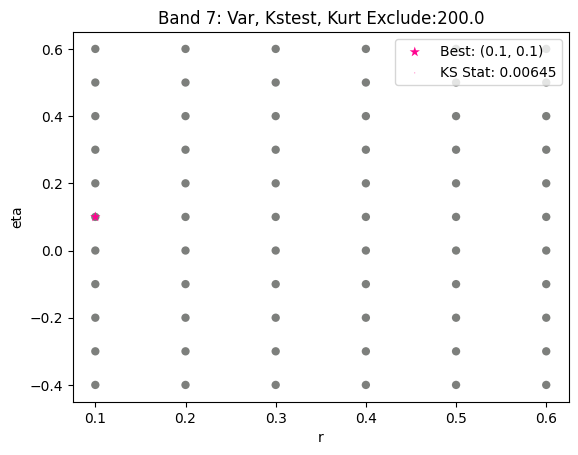

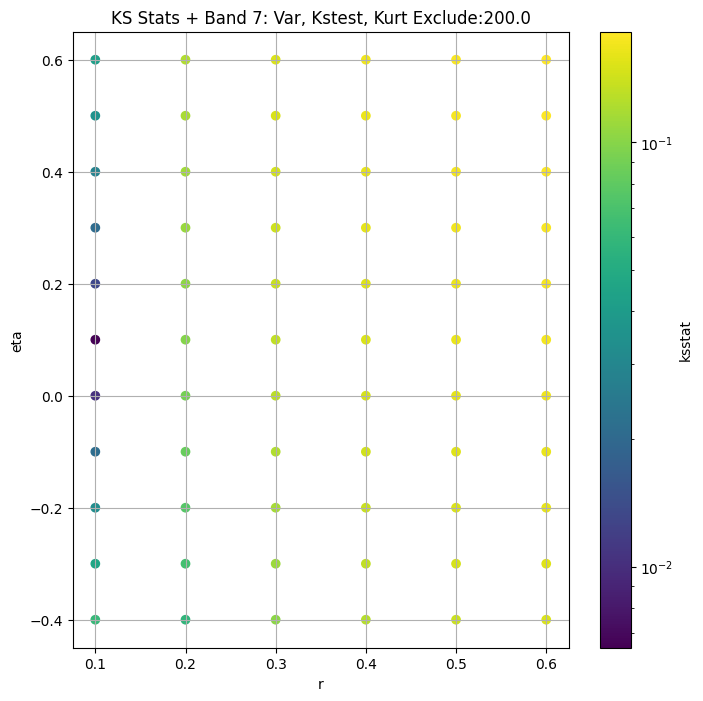

####
Band  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.017496524868381047 0.37881282


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.01462845030374016 0.31235176


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.014525758291804247 0.2871652


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.011362392224425366 0.26804617


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.013589487106214437 0.2523458


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.009466257898331443 0.22731394


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.008342321810670073 0.20769107


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.008714507147969841 0.19160889


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.006473518410185184 0.17801218


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.0070651811073474385 0.16631056


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.008875322008320554 0.13898829
Number of samples: 100000, Without approximation : 14562240.0


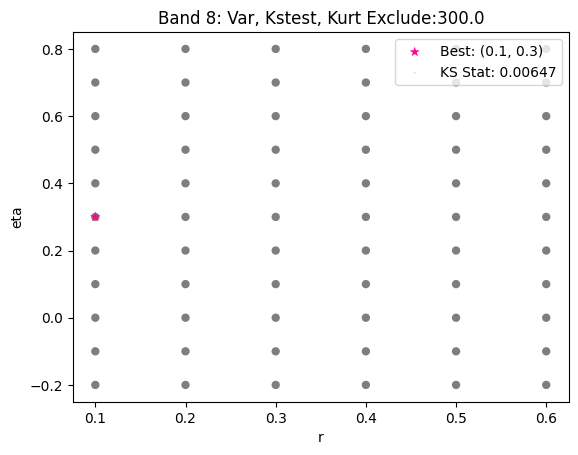

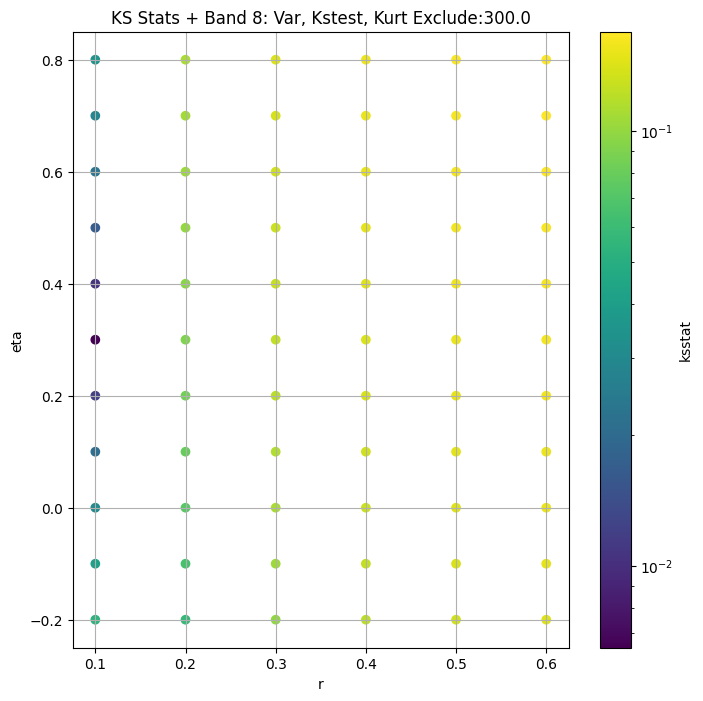

####
Band  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.022647794336239757 0.26798713


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.018004427890620622 0.20407607


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.0143438957956733 0.18153907


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.012988977885300512 0.16507903


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.012943110788661838 0.15200318


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.010239911683116776 0.13192916


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.0066002095418083995 0.11684905


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.00714275005625753 0.1048985


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.005689846103952783 0.09512833


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.006239059216210377 0.086965784


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.0074457639874823045 0.06892785
Number of samples: 100000, Without approximation : 14789775.0


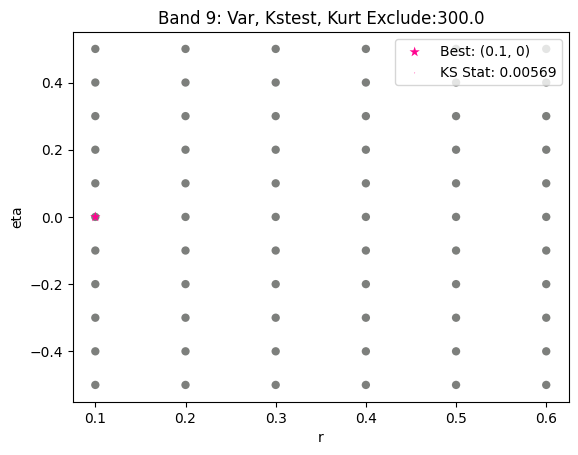

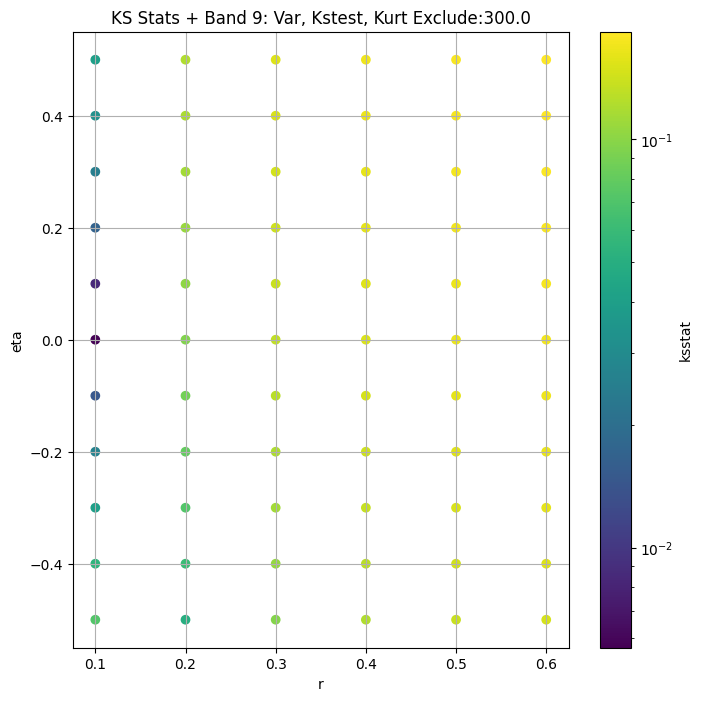

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05
band,,,,,,,,,,,,,,
2,74.898780,60.582530,96.669820,81.446304,26.894161,243.59503,7281120.0,0.002694,0.2,-0.6,5.861164e-03,50.0,60.110817,0.000503
3,29.164696,24.408790,36.506966,59.589302,21.501167,199.60582,7281120.0,0.002513,0.3,-0.9,5.843606e-01,75.0,23.449781,0.000503
4,17.610868,13.961561,26.559898,175.805450,27.692068,671.88556,7281120.0,0.003503,0.3,-1.0,4.776466e-01,100.0,12.698509,0.000503
5,14.123198,10.813453,22.130413,221.240480,40.726257,784.53310,29124480.0,0.005322,0.1,-0.3,7.940290e-12,75.0,10.163062,0.000252
6,4.266520,3.277308,6.358692,176.742780,42.272380,626.33920,14562240.0,0.006079,0.1,-0.2,1.229953e-12,100.0,2.886146,0.000356
7,0.997323,0.778492,1.400140,131.501680,39.621890,462.65570,14562240.0,0.006450,0.1,0.1,4.904242e-14,200.0,0.581725,0.000356
8,0.378813,0.285862,0.610266,248.776430,44.356453,863.71990,14562240.0,0.006474,0.1,0.3,5.814809e-15,300.0,0.178012,0.000356
9,0.267987,0.185539,0.490132,447.445000,68.904110,1361.17110,14789775.0,0.005690,0.1,0.0,1.336634e-14,300.0,0.095128,0.000353


In [19]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [20]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Band 2


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 2, 50.0 + 100 = 150, ksstat: 0.0037951862901118814, var: 50.86355209350586


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 2, 50.0 + 75 = 125, ksstat: 0.003317447904377803, var: 52.601402282714844


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 2, 50.0 + 50 = 100, ksstat: 0.002993410624739401, var: 54.62216567993164


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 2, 50.0 + 25 = 75, ksstat: 0.0024094647058259186, var: 57.04624938964844


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 2, 50.0 + 0 = 50, ksstat: 0.002325854134468383, var: 60.110816955566406


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 2, 50.0 + -25 = 25, ksstat: 0.001742603206574378, var: 64.4194564819336


  0%|          | 0/1251 [00:00<?, ?it/s]

Finding Minimum after computing 1251 CDFs
band 2, 50.0 + -50 = 0, ksstat: 0.002810299313650011, var: 74.8987808227539
Number of samples: 100000, Without approximation : 7281120.0


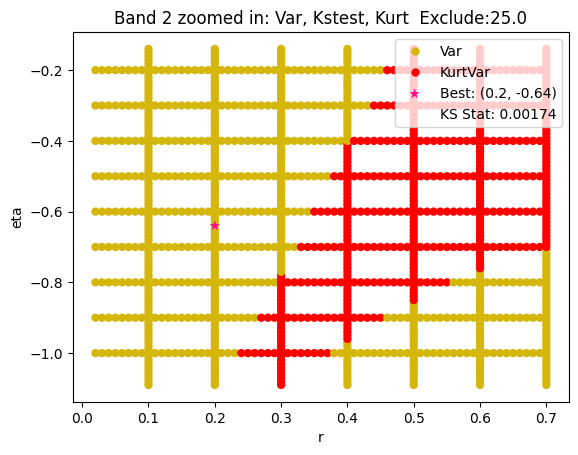

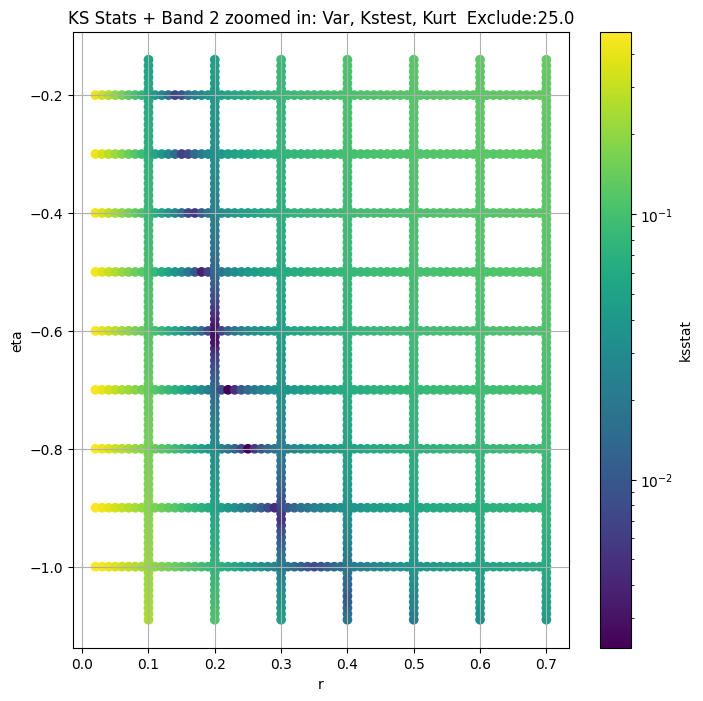

Band 3


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 75.0 + 100 = 175, ksstat: 0.003938606726257218, var: 20.615947723388672


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 75.0 + 75 = 150, ksstat: 0.00348601512283629, var: 21.19528579711914


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 75.0 + 50 = 125, ksstat: 0.0030788210978437425, var: 21.844247817993164


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 75.0 + 25 = 100, ksstat: 0.003043134954279797, var: 22.584638595581055


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 75.0 + 0 = 75, ksstat: 0.0024570616816661367, var: 23.44978141784668


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 75.0 + -25 = 50, ksstat: 0.0017646156750513696, var: 24.50943374633789


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 75.0 + -50 = 25, ksstat: 0.0023128354195101064, var: 25.92688751220703


  0%|          | 0/1410 [00:00<?, ?it/s]

Finding Minimum after computing 1410 CDFs
band 3, 75.0 + -75 = 0, ksstat: 0.002449880286831907, var: 29.164695739746094
Number of samples: 100000, Without approximation : 7281120.0


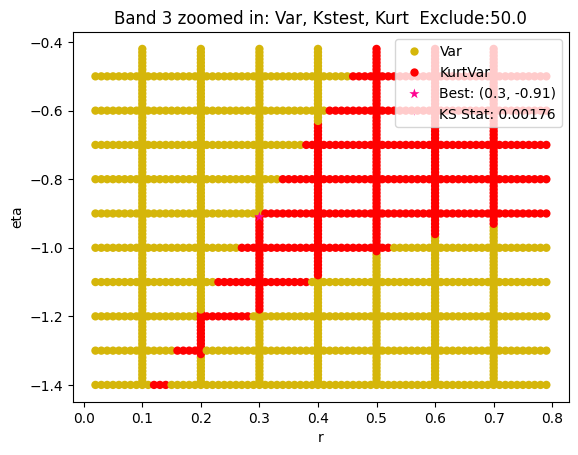

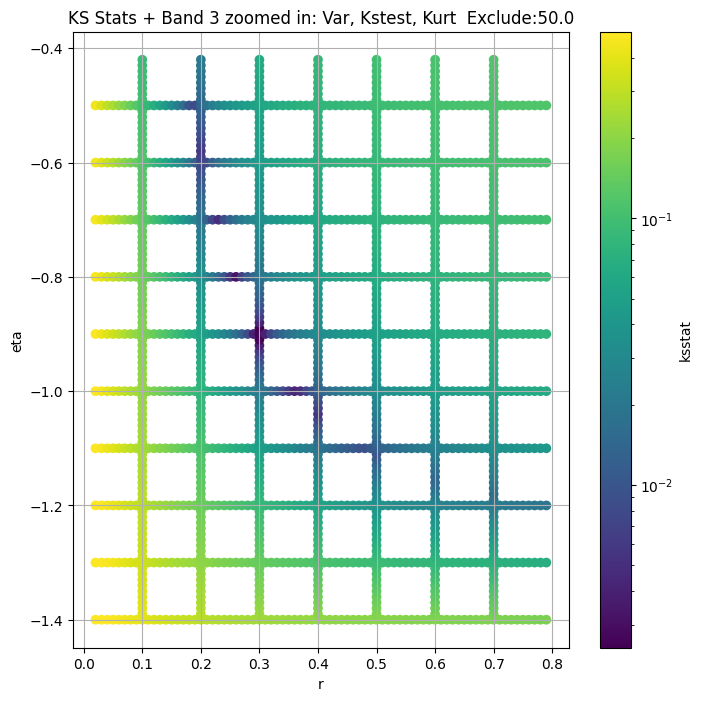

Band 4


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
band 4, 100.0 + 100 = 200, ksstat: 0.005070303616218623, var: 11.06346607208252


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
band 4, 100.0 + 75 = 175, ksstat: 0.004775502054067356, var: 11.404790878295898


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
band 4, 100.0 + 50 = 150, ksstat: 0.004018106154372432, var: 11.783984184265137


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
band 4, 100.0 + 25 = 125, ksstat: 0.0036535638074565724, var: 12.210314750671387


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
band 4, 100.0 + 0 = 100, ksstat: 0.003503442071709384, var: 12.698509216308594


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
band 4, 100.0 + -25 = 75, ksstat: 0.003888774631918168, var: 13.272003173828125


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
band 4, 100.0 + -50 = 50, ksstat: 0.00371383034558026, var: 13.980338096618652


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
band 4, 100.0 + -75 = 25, ksstat: 0.002167165164401519, var: 14.93669319152832


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
band 4, 100.0 + -100 = 0, ksstat: 0.0018258726731136266, var: 17.610868453979492
Number of samples: 100000, Without approximation : 7281120.0


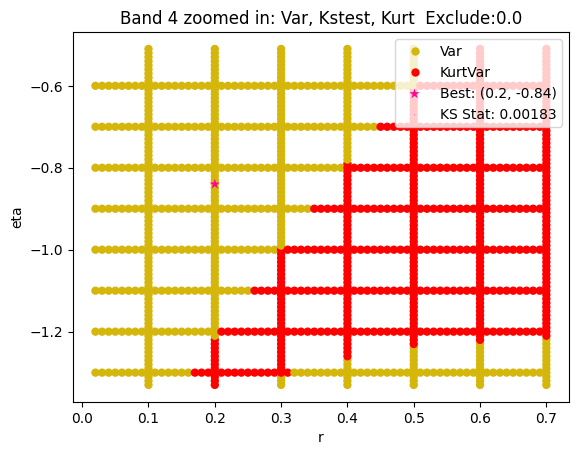

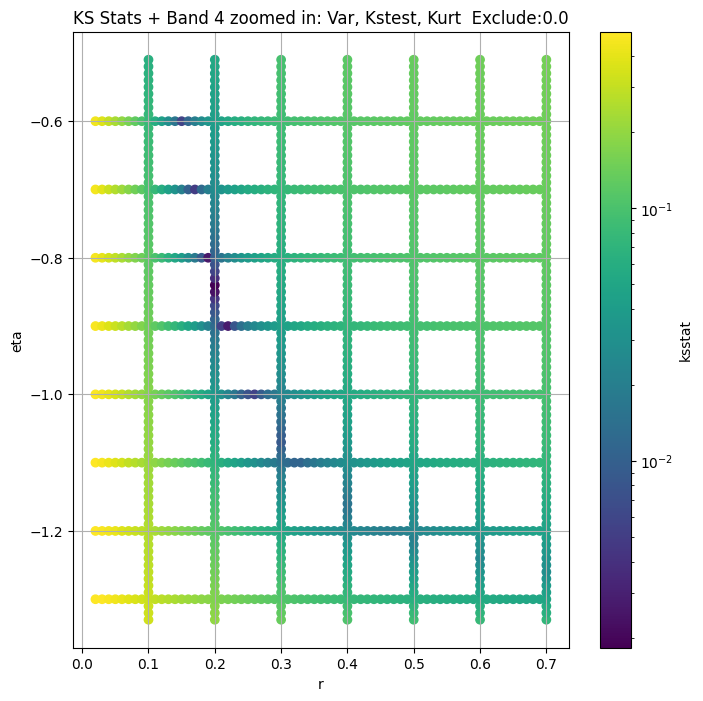

Band 5


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 5, 75.0 + 100 = 175, ksstat: 0.006126443220864097, var: 8.353574752807617


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 5, 75.0 + 75 = 150, ksstat: 0.0063742387466420025, var: 8.722868919372559


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 5, 75.0 + 50 = 125, ksstat: 0.005897850958260505, var: 9.136861801147461


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 5, 75.0 + 25 = 100, ksstat: 0.005303904643346938, var: 9.60942554473877


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 5, 75.0 + 0 = 75, ksstat: 0.005194004923192908, var: 10.16306209564209


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 5, 75.0 + -25 = 50, ksstat: 0.0047087308497175615, var: 10.836799621582031


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 5, 75.0 + -50 = 25, ksstat: 0.004460821555577067, var: 11.726324081420898


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
band 5, 75.0 + -75 = 0, ksstat: 0.0059957183456709195, var: 14.123197555541992
Number of samples: 100000, Without approximation : 29124480.0


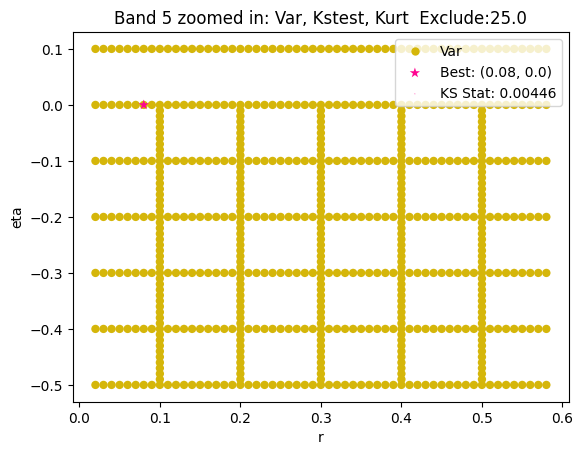

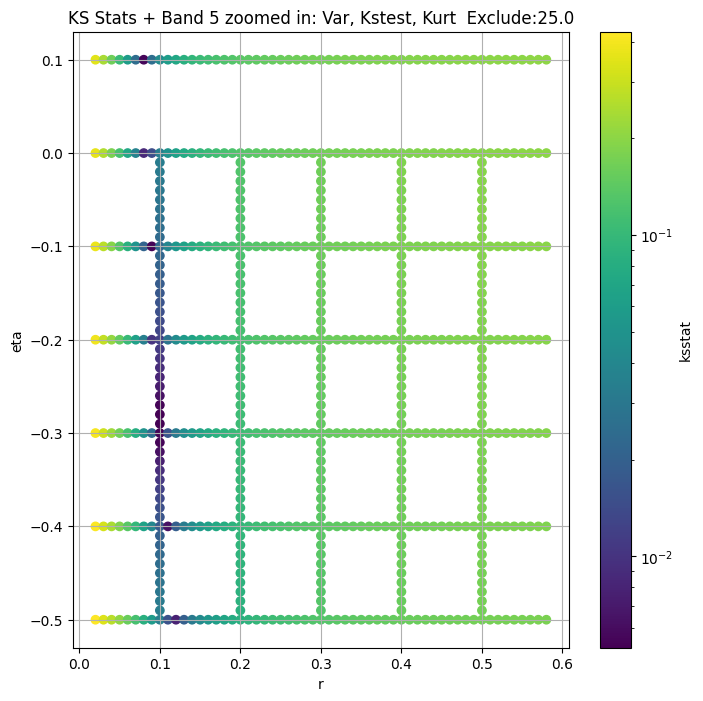

Band 6


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 100.0 + 100 = 200, ksstat: 0.006833694412777543, var: 2.402031183242798


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 100.0 + 75 = 175, ksstat: 0.006331102676298297, var: 2.5028254985809326


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 100.0 + 50 = 150, ksstat: 0.006085807391965153, var: 2.61482310295105


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 100.0 + 25 = 125, ksstat: 0.005771982274900641, var: 2.7411630153656006


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 100.0 + 0 = 100, ksstat: 0.005372900813027638, var: 2.886146068572998


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 100.0 + -25 = 75, ksstat: 0.0063502784909659216, var: 3.056962251663208


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 100.0 + -50 = 50, ksstat: 0.005662953033657492, var: 3.2664928436279297


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 100.0 + -75 = 25, ksstat: 0.008568140563589899, var: 3.547292470932007


  0%|          | 0/895 [00:00<?, ?it/s]

Finding Minimum after computing 895 CDFs
band 6, 100.0 + -100 = 0, ksstat: 0.008135645664968605, var: 4.266520023345947
Number of samples: 100000, Without approximation : 14562240.0


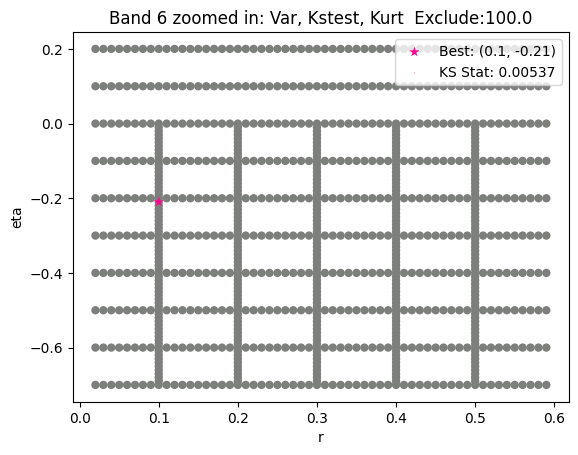

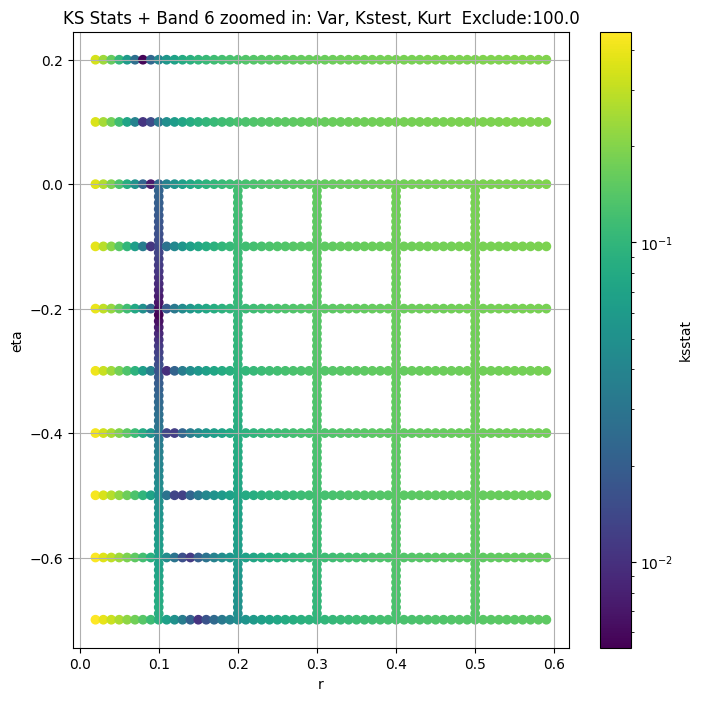

Band 7


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 7, 200.0 + 100 = 300, ksstat: 0.007271886409850487, var: 0.5052364468574524


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 7, 200.0 + 75 = 275, ksstat: 0.006984130700353865, var: 0.5222144722938538


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 7, 200.0 + 50 = 250, ksstat: 0.006584953355009535, var: 0.54045569896698


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 7, 200.0 + 25 = 225, ksstat: 0.006343518618856472, var: 0.5601974725723267


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 7, 200.0 + 0 = 200, ksstat: 0.006150625551097633, var: 0.5817253589630127


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 7, 200.0 + -25 = 175, ksstat: 0.006159517976151737, var: 0.6053337454795837


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 7, 200.0 + -50 = 150, ksstat: 0.005678206015679969, var: 0.63149493932724


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 7, 200.0 + -75 = 125, ksstat: 0.0056271924772629545, var: 0.6608947515487671


  0%|          | 0/702 [00:00<?, ?it/s]

Finding Minimum after computing 702 CDFs
band 7, 200.0 + -100 = 100, ksstat: 0.0068147183810988166, var: 0.6944398283958435
Number of samples: 100000, Without approximation : 14562240.0


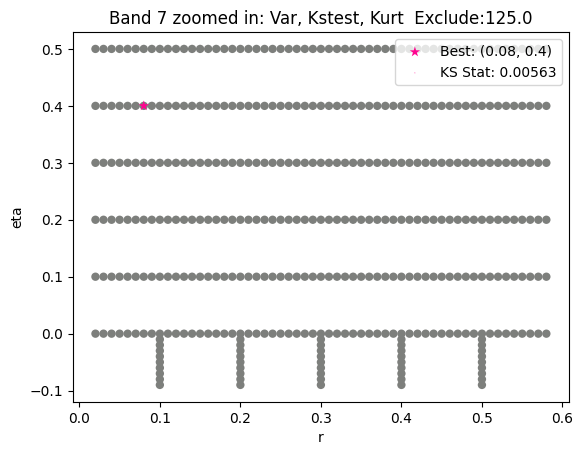

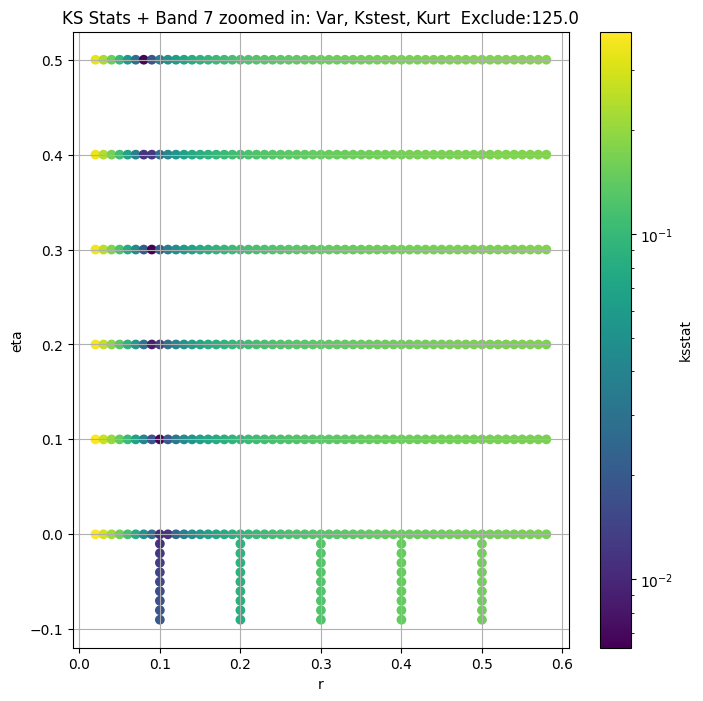

Band 8


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 8, 300.0 + 100 = 400, ksstat: 0.0075165325600818, var: 0.1560838520526886


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 8, 300.0 + 75 = 375, ksstat: 0.007174507619007743, var: 0.16103240847587585


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 8, 300.0 + 50 = 350, ksstat: 0.006830384926974603, var: 0.16631056368350983


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 8, 300.0 + 25 = 325, ksstat: 0.006604079711652914, var: 0.17195460200309753


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 8, 300.0 + 0 = 300, ksstat: 0.006473518410185184, var: 0.1780121773481369


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 8, 300.0 + -25 = 275, ksstat: 0.006234797093000621, var: 0.18454155325889587


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 8, 300.0 + -50 = 250, ksstat: 0.006274409484606169, var: 0.19160889089107513


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 8, 300.0 + -75 = 225, ksstat: 0.005679472623576416, var: 0.19928357005119324


  0%|          | 0/612 [00:00<?, ?it/s]

Finding Minimum after computing 612 CDFs
band 8, 300.0 + -100 = 200, ksstat: 0.0070202954963828335, var: 0.20769107341766357
Number of samples: 100000, Without approximation : 14562240.0


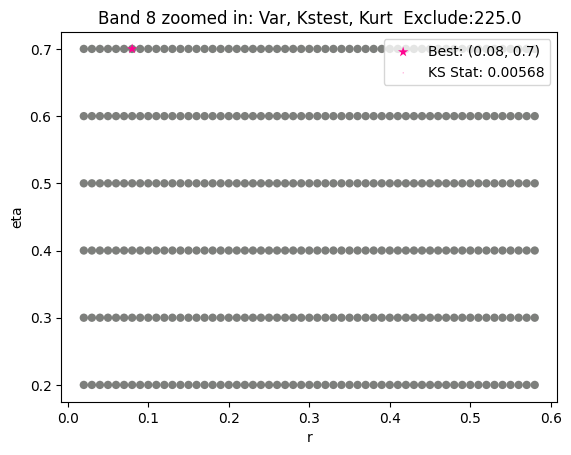

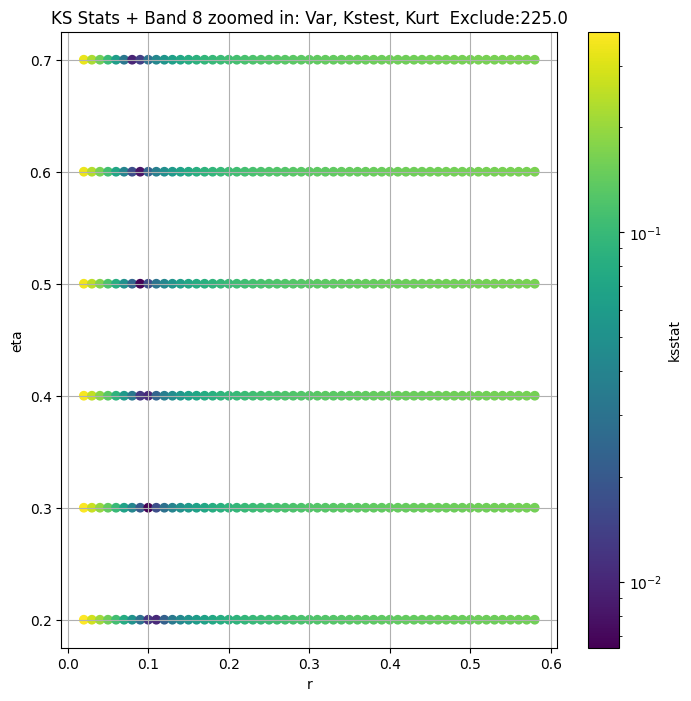

Band 9


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 9, 300.0 + 100 = 400, ksstat: 0.006596951438405379, var: 0.08004545420408249


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 9, 300.0 + 75 = 375, ksstat: 0.006294190136839425, var: 0.08336972445249557


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 9, 300.0 + 50 = 350, ksstat: 0.0061107399558299, var: 0.08696578443050385


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 9, 300.0 + 25 = 325, ksstat: 0.005889441153724189, var: 0.09087356925010681


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 9, 300.0 + 0 = 300, ksstat: 0.005689846103952783, var: 0.09512832760810852


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 9, 300.0 + -25 = 275, ksstat: 0.005252411236225302, var: 0.09978290647268295


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 9, 300.0 + -50 = 250, ksstat: 0.005013449667399066, var: 0.10489849746227264


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 9, 300.0 + -75 = 225, ksstat: 0.004846891180700183, var: 0.11055261641740799


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
band 9, 300.0 + -100 = 200, ksstat: 0.004774147540692622, var: 0.11684904992580414
Number of samples: 100000, Without approximation : 14789775.0


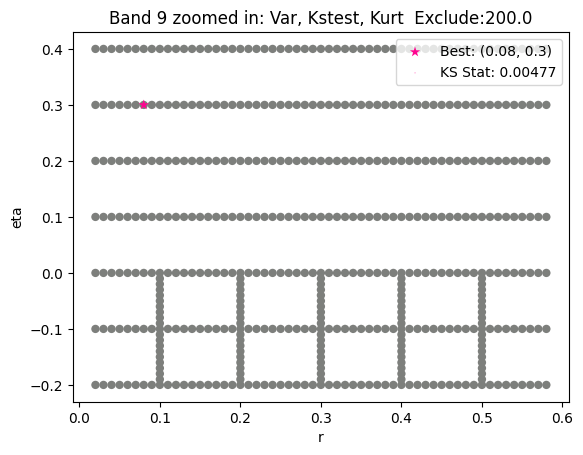

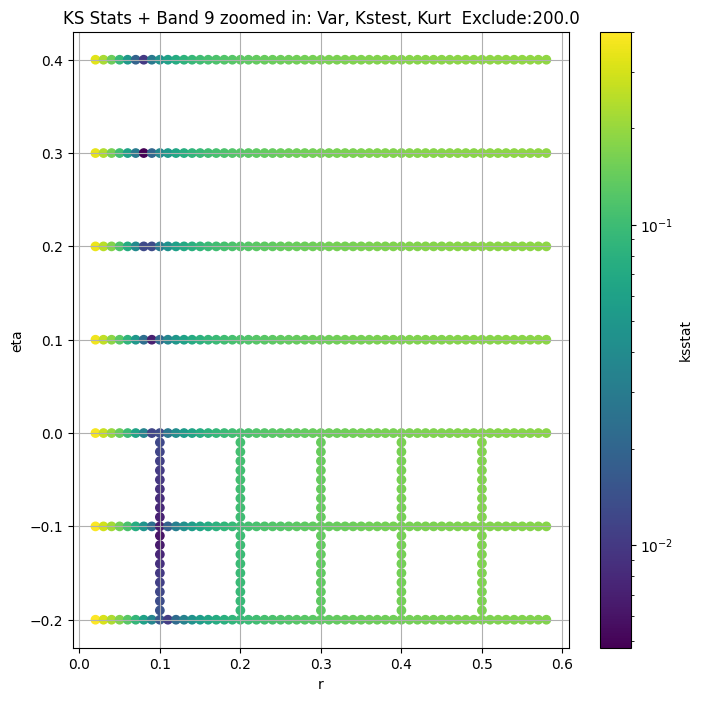

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,initial_scale,initial_exclude_cutoff,best_augmented_var,kstest_stat_cutoff_0.05,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff,n_pval_0.05
band,,,,,,,,,,,,,,,,,,,,
2,74.898780,60.582530,96.669820,81.446304,26.894161,243.59503,7281120.0,0.002694,0.2,-0.6,5.861164e-03,50.0,64.419456,0.000503,0.001743,0.20,-0.64,7.405105e-03,25.0,615033
3,29.164696,24.408790,36.506966,59.589302,21.501167,199.60582,7281120.0,0.002513,0.3,-0.9,5.843606e-01,75.0,24.509434,0.000503,0.001765,0.30,-0.91,6.348859e-01,50.0,575946
4,17.610868,13.961561,26.559898,175.805450,27.692068,671.88556,7281120.0,0.003503,0.3,-1.0,4.776466e-01,100.0,17.610868,0.000503,0.001826,0.20,-0.84,5.091657e-03,0.0,575946
5,14.123198,10.813453,22.130413,221.240480,40.726257,784.53310,29124480.0,0.005322,0.1,-0.3,7.940290e-12,75.0,11.726324,0.000252,0.004461,0.08,0.00,5.810987e-17,25.0,95989
6,4.266520,3.277308,6.358692,176.742780,42.272380,626.33920,14562240.0,0.006079,0.1,-0.2,1.229953e-12,100.0,2.886146,0.000356,0.005373,0.10,-0.21,1.304624e-12,100.0,63993
7,0.997323,0.778492,1.400140,131.501680,39.621890,462.65570,14562240.0,0.006450,0.1,0.1,4.904242e-14,200.0,0.660895,0.000356,0.005627,0.08,0.40,3.077913e-19,125.0,56883
8,0.378813,0.285862,0.610266,248.776430,44.356453,863.71990,14562240.0,0.006474,0.1,0.3,5.814809e-15,300.0,0.199284,0.000356,0.005679,0.08,0.70,2.037872e-20,225.0,56883
9,0.267987,0.185539,0.490132,447.445000,68.904110,1361.17110,14789775.0,0.005690,0.1,0.0,1.336634e-14,300.0,0.116849,0.000353,0.004774,0.08,0.30,9.430798e-20,200.0,82255


In [21]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

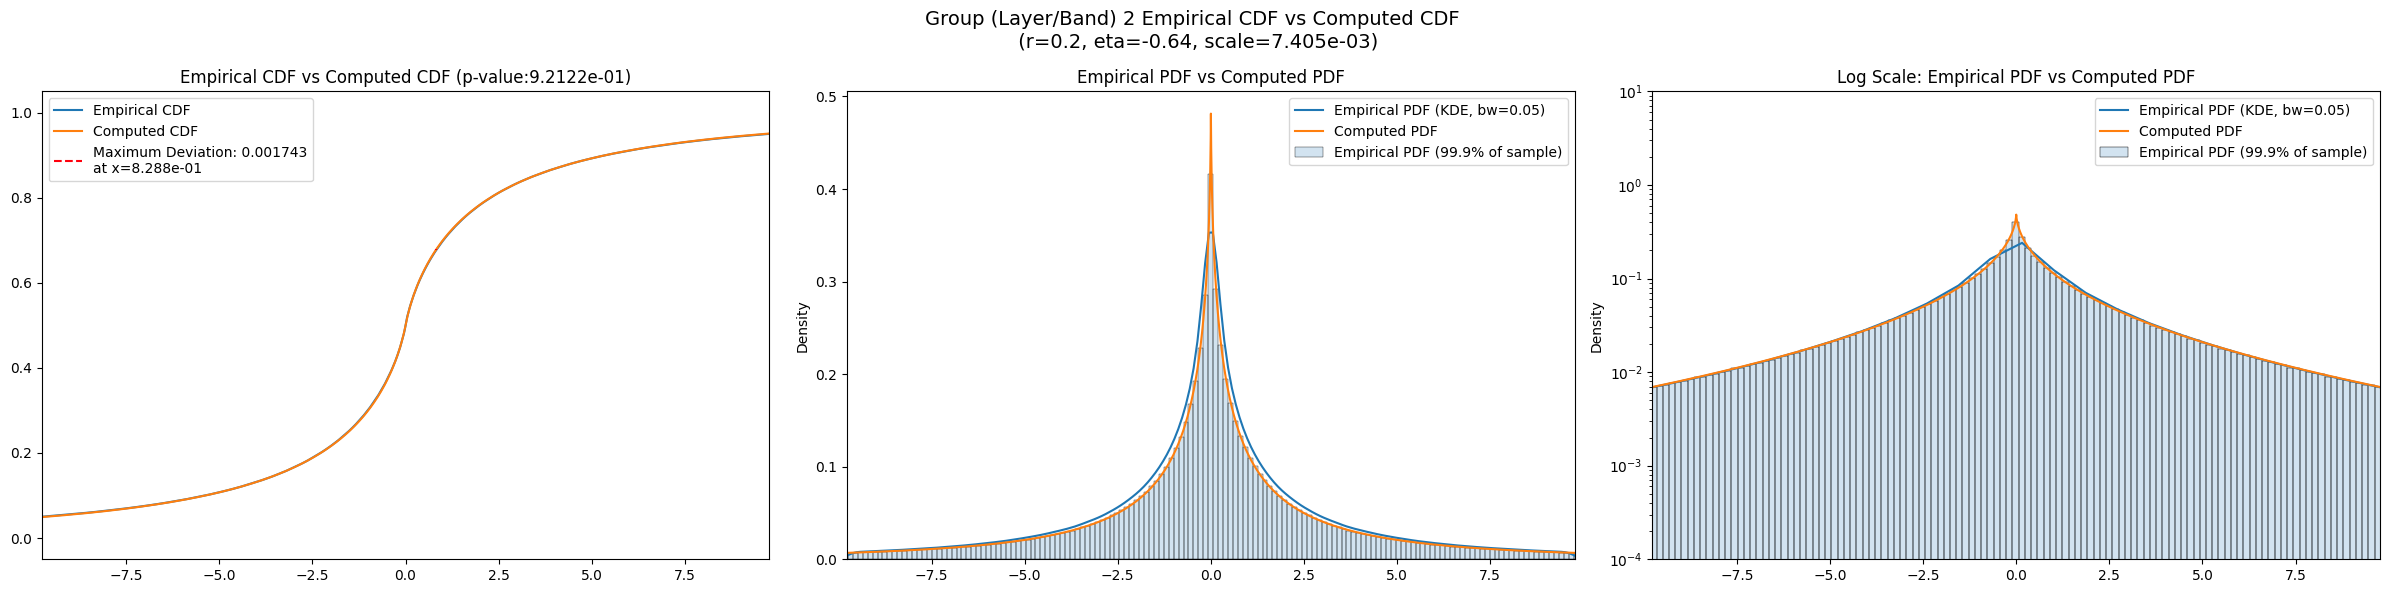

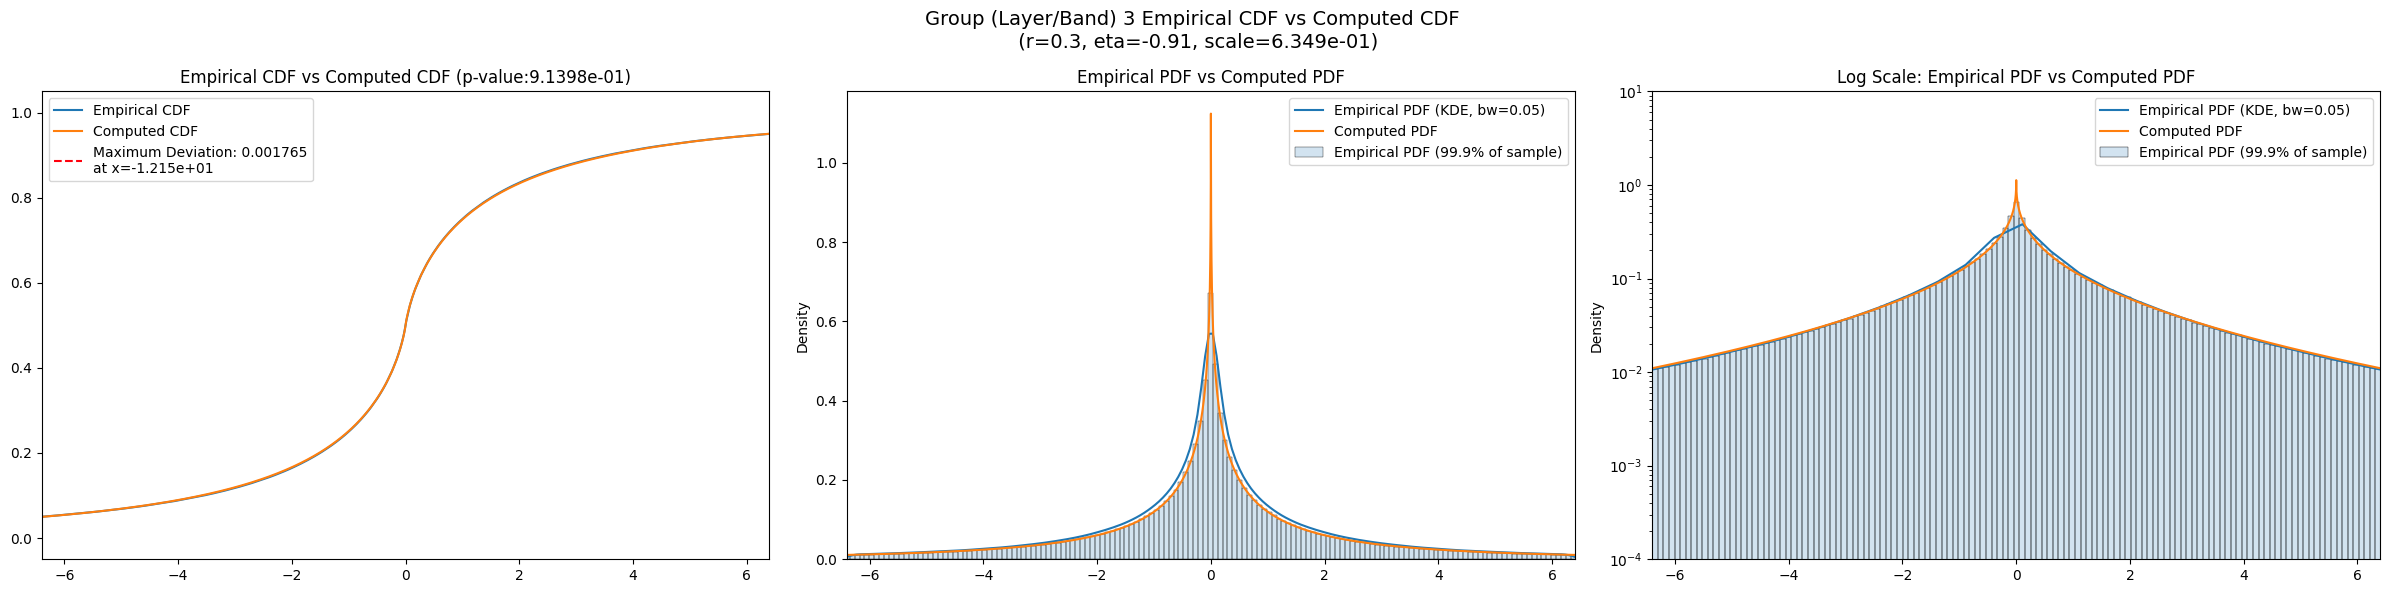

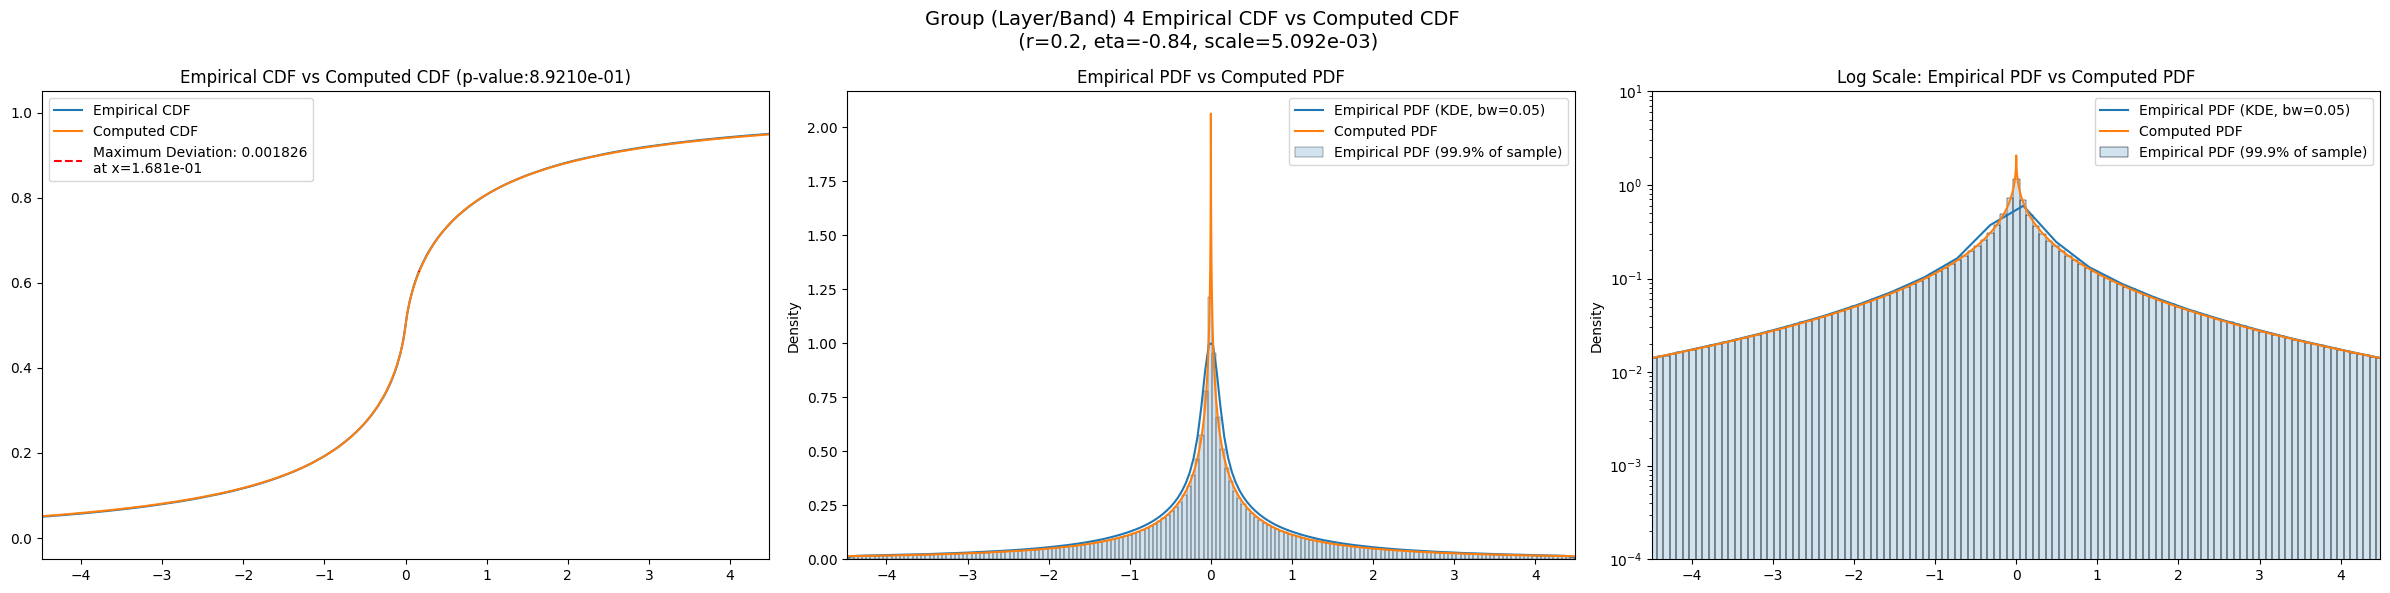

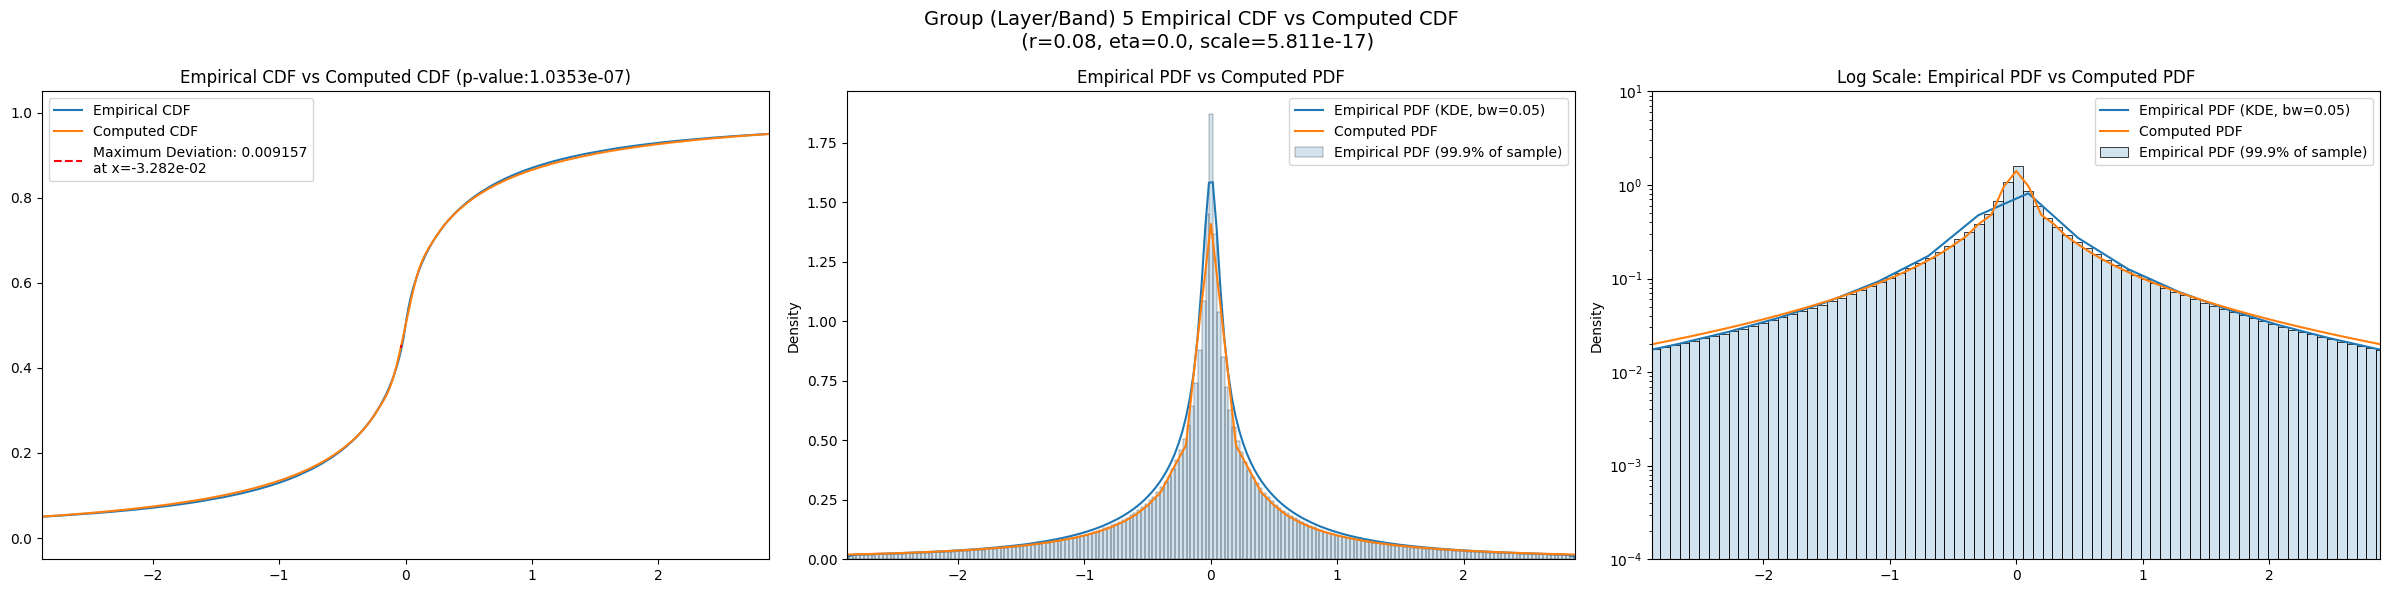

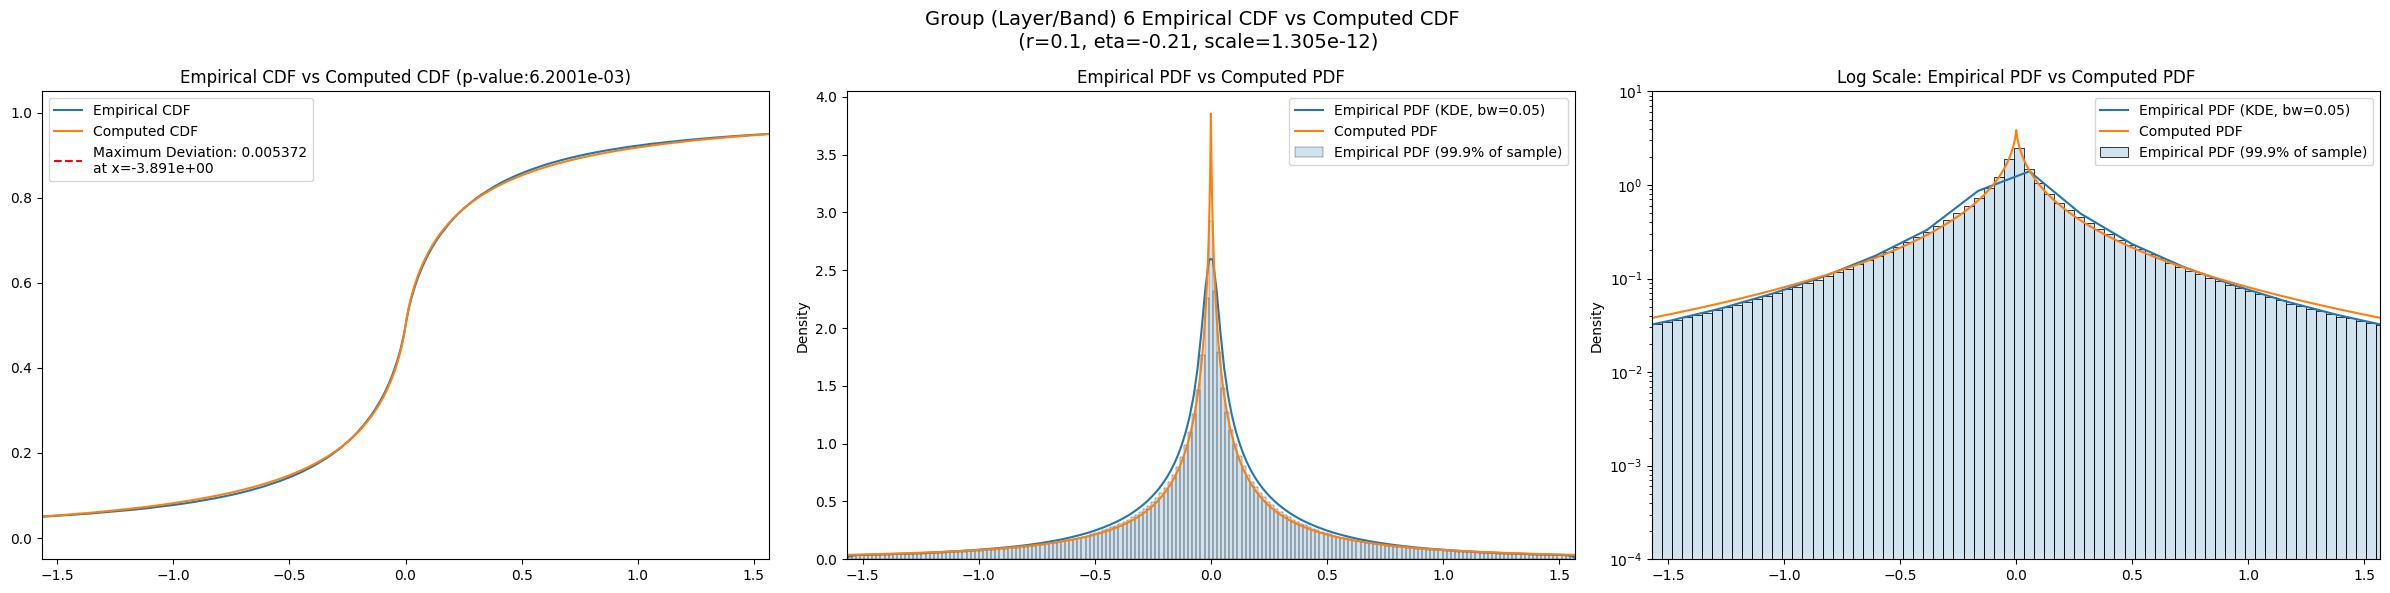

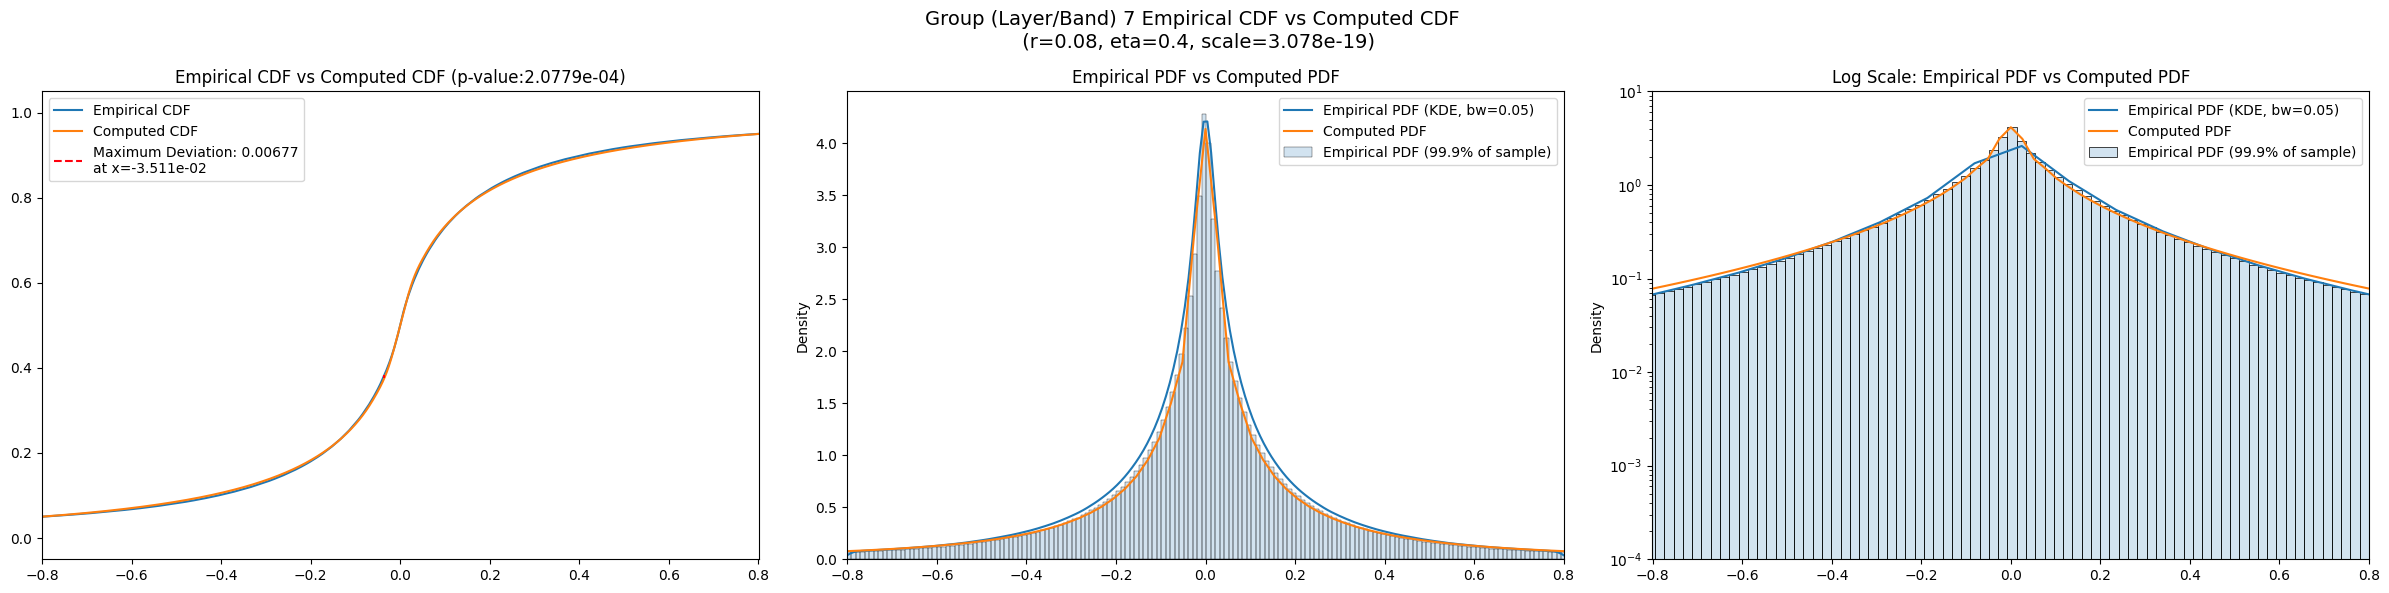

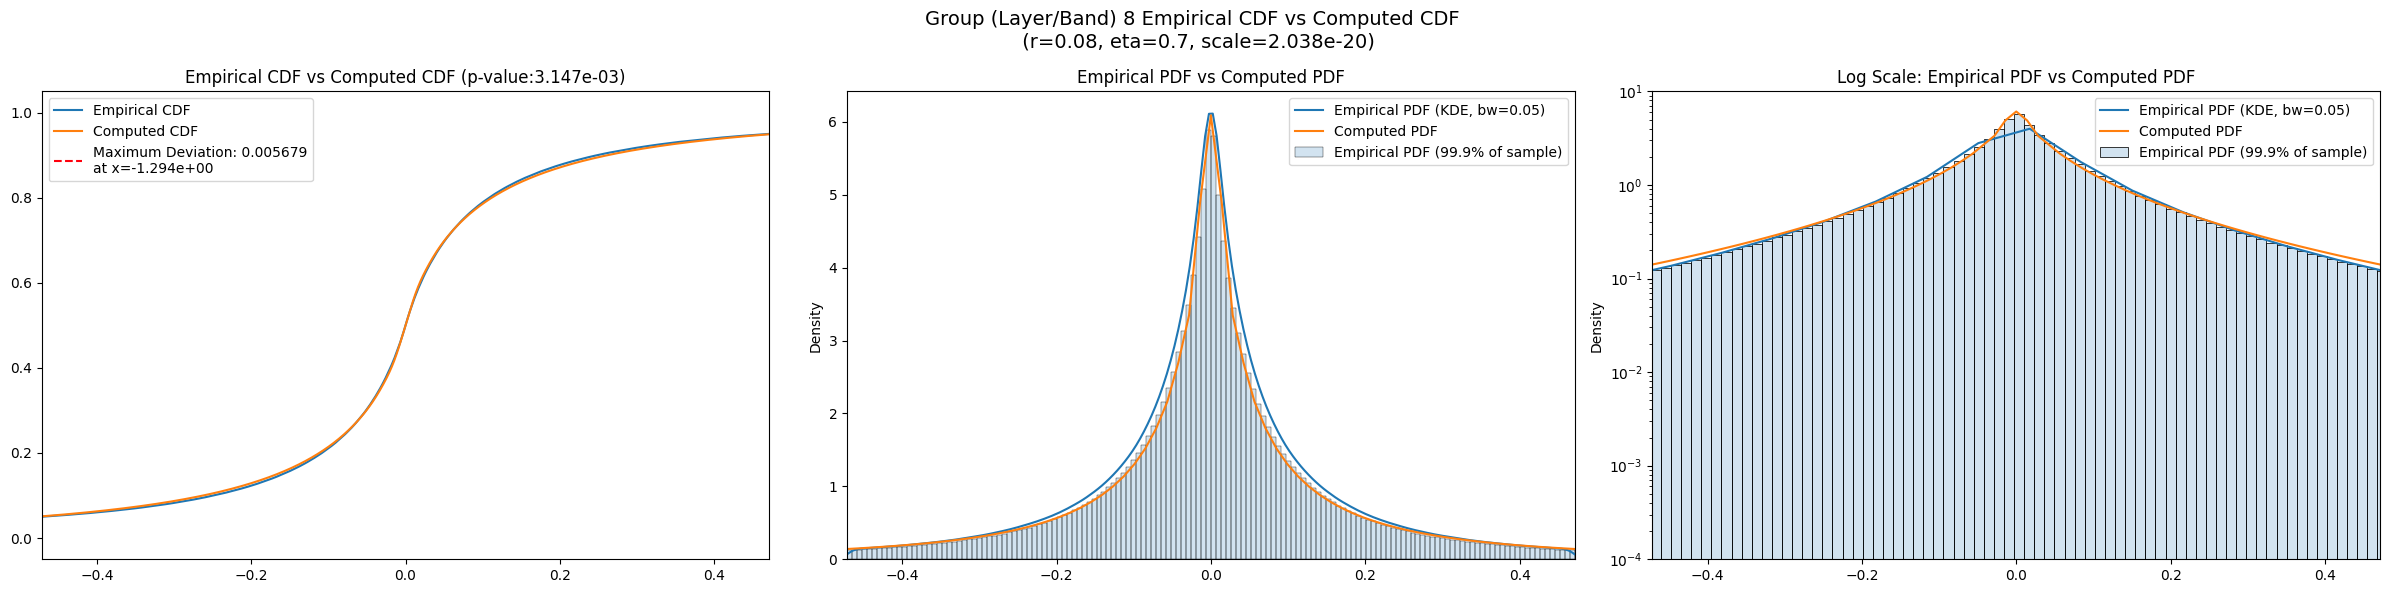

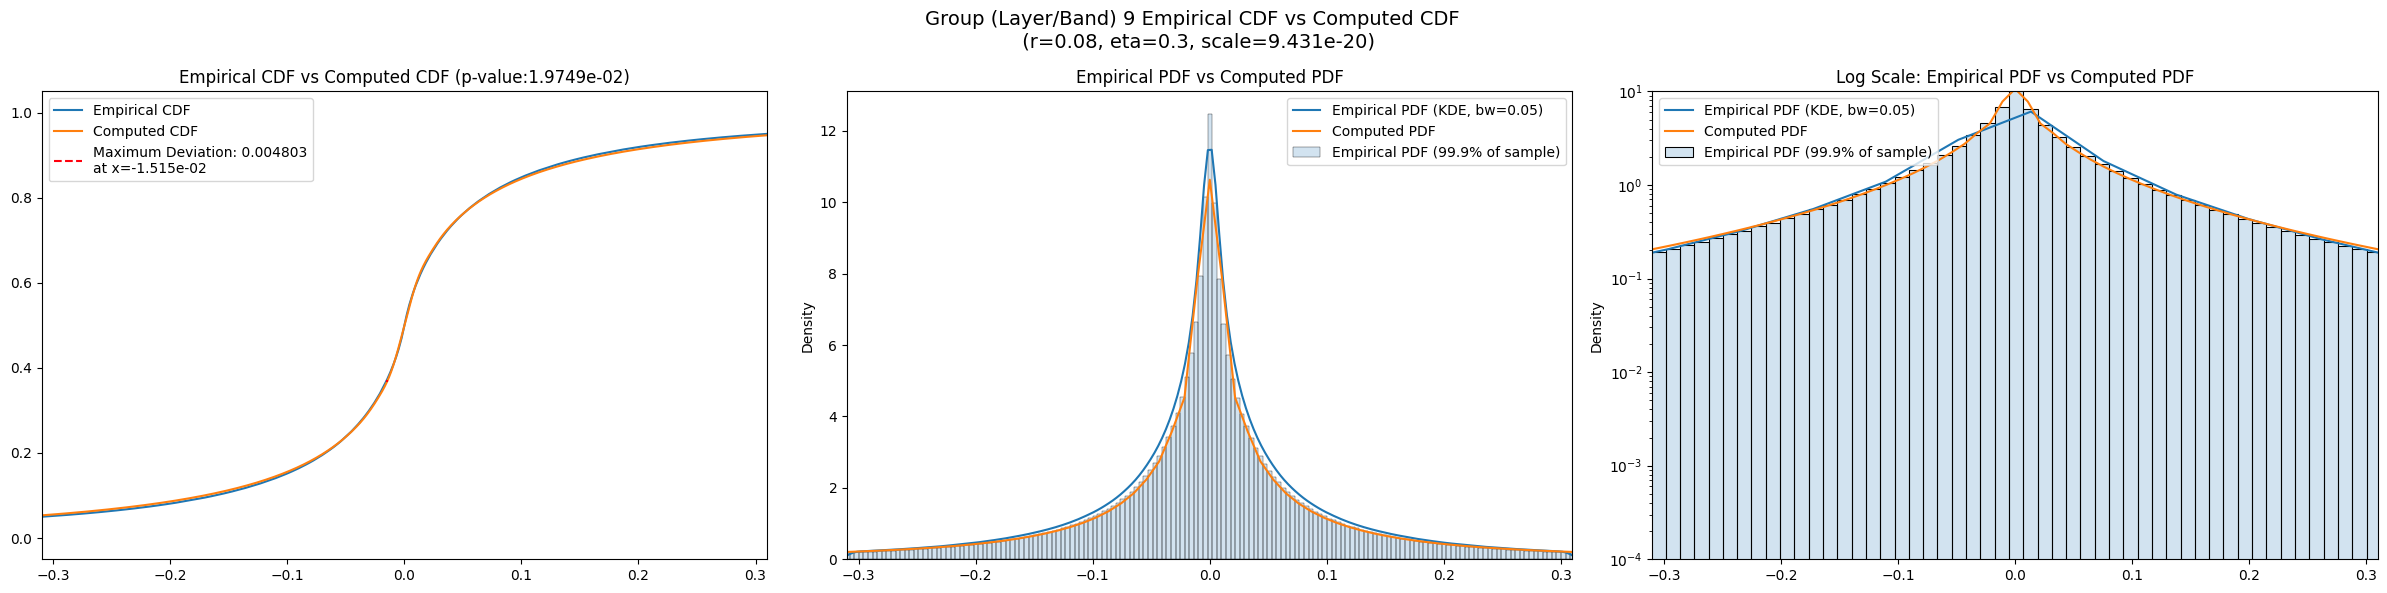

C:\Users\Henry\AppData\Local\Temp\ipykernel_11808\82260372.py:10: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)


In [22]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [23]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [24]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

,obs_var,var_lower,var_upper,obs_kurt,kurt_lower,kurt_upper,total_samples,kstest_stat_initial,initial_r,initial_eta,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
band,,,,,,,,,,,,,,,,,,,,,
2,74.898780,60.582530,96.669820,81.446304,26.894161,243.59503,7281120.0,0.002694,0.2,-0.6,...,2.983980,0.067887,0.0,2.606490,0.042005,0.0,2.019500,0.042099,0.0,1.246630e-19
3,29.164696,24.408790,36.506966,59.589302,21.501167,199.60582,7281120.0,0.002513,0.3,-0.9,...,1.925620,0.069803,0.0,1.670780,0.044174,0.0,1.296770,0.044909,0.0,4.050225e-20
4,17.610868,13.961561,26.559898,175.805450,27.692068,671.88556,7281120.0,0.003503,0.3,-1.0,...,1.189210,0.078134,0.0,1.025690,0.053222,0.0,0.790629,0.053755,0.0,1.646185e-21
5,14.123198,10.813453,22.130413,221.240480,40.726257,784.53310,29124480.0,0.005322,0.1,-0.3,...,0.702649,0.076660,0.0,0.617427,0.052049,0.0,0.469411,0.050587,0.0,0.000000e+00
6,4.266520,3.277308,6.358692,176.742780,42.272380,626.33920,14562240.0,0.006079,0.1,-0.2,...,0.408482,0.072403,0.0,0.360825,0.047610,0.0,0.274589,0.045826,0.0,0.000000e+00
7,0.997323,0.778492,1.400140,131.501680,39.621890,462.65570,14562240.0,0.006450,0.1,0.1,...,0.229815,0.067293,0.0,0.204065,0.042164,0.0,0.156274,0.039912,0.0,0.000000e+00
8,0.378813,0.285862,0.610266,248.776430,44.356453,863.71990,14562240.0,0.006474,0.1,0.3,...,0.146295,0.063117,0.0,0.130132,0.037646,0.0,0.100343,0.035065,0.0,0.000000e+00
9,0.267987,0.185539,0.490132,447.445000,68.904110,1361.17110,14789775.0,0.005690,0.1,0.0,...,0.089518,0.068894,0.0,0.078732,0.043408,0.0,0.060562,0.042441,0.0,3.177055e-293


## Results

In [25]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [26]:
master_df.filter(regex="kstest_stat.*")

,kstest_stat_initial,kstest_stat_cutoff_0.05,kstest_stat_best,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t
band,,,,,,
2,0.002694,0.000503,0.001743,0.067887,0.042005,0.042099
3,0.002513,0.000503,0.001765,0.069803,0.044174,0.044909
4,0.003503,0.000503,0.001826,0.078134,0.053222,0.053755
5,0.005322,0.000252,0.004461,0.076660,0.052049,0.050587
6,0.006079,0.000356,0.005373,0.072403,0.047610,0.045826
7,0.006450,0.000356,0.005627,0.067293,0.042164,0.039912
8,0.006474,0.000356,0.005679,0.063117,0.037646,0.035065
9,0.005690,0.000353,0.004774,0.068894,0.043408,0.042441


In [27]:
master_df.filter(regex="best.*")

,best_augmented_var,kstest_stat_best,best_r,best_eta,best_scale,best_exclude_cutoff
band,,,,,,
2,64.419456,0.001743,0.20,-0.64,7.405105e-03,25.0
3,24.509434,0.001765,0.30,-0.91,6.348859e-01,50.0
4,17.610868,0.001826,0.20,-0.84,5.091657e-03,0.0
5,11.726324,0.004461,0.08,0.00,5.810987e-17,25.0
6,2.886146,0.005373,0.10,-0.21,1.304624e-12,100.0
7,0.660895,0.005627,0.08,0.40,3.077913e-19,125.0
8,0.199284,0.005679,0.08,0.70,2.037872e-20,225.0
9,0.116849,0.004774,0.08,0.30,9.430798e-20,200.0
